In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [49]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, inspect

In [51]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [52]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/4w/dqq6x1t91hvgn2hnhb1zlk9r0000gn/T/ipykernel_63446/1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [53]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [54]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [55]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [57]:
# Import inspector func above to find column names so you can perform proper querys.
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for c in measurement_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [58]:
station_columns = inspector.get_columns("station")
for c in station_columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


**now we know that the date column to query exists in the measurement table of the hawaii sqlite file and that it is in string form**


In [59]:
# Find the most recent date in the data set.
most_recent_date_query = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

most_recent_date_query

('2017-08-23',)

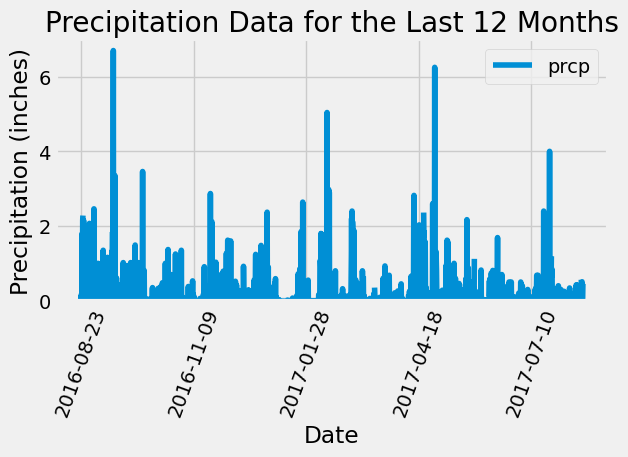

In [62]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# the start date was created into object from finding most_recent_date in cell above from Measurement class

values = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

# Check to see if correct values were generated via for loop and printing values
# for value in values:
#     print(values)

# Calculate the date one year from the last date in data set.
    # value one year from the start date is 2016-08-23, by filtering for values greater than 2016-08-22 we include all days in that range


# Perform a query to retrieve the data and precipitation scores
    # query done for dates and precipitation and saved in the values variable above

# Save the query results as a Pandas DataFrame and set the index to the date column

annual_prcp = pd.DataFrame(values)
annual_prcp = annual_prcp.set_index("date")
annual_prcp

# Sort the dataframe by date
    # date already sorted in ascending order since we queried the dates and precip and sorted when creating var "values"

# Use Pandas Plotting with Matplotlib to plot the data
annual_prcp.plot()
plt.ylim(0,7)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.tight_layout()
plt.show()


In [65]:
# Use Pandas to calculate the summary statistics for the precipitation data
annual_prcp.rename(columns={'prcp': 'Precipitation'}, inplace=True)

annual_prcp.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [67]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()

total_stations

9

In [70]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station).label('observation_count')) \
                        .group_by(Measurement.station) \
                        .order_by(func.count(Measurement.station).desc()) \
                        .all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find most Active station ID:
most_active_station_id = station_counts[0][0]



results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                  .filter(Measurement.station == most_active_station_id) \
                  .all()
for result in results:
    min_temp, max_temp, avg_temp = result
    print(f"Lowest Temperature: {min_temp}, Highest Temperature: {max_temp}, Average Temperature: {avg_temp}")

Lowest Temperature: 54.0, Highest Temperature: 85.0, Average Temperature: 71.66378066378067


<function matplotlib.pyplot.show(close=None, block=None)>

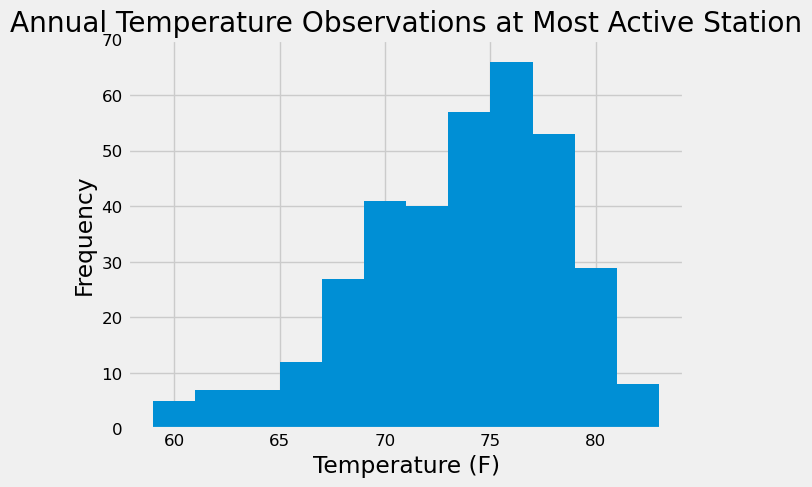

In [80]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs) \
                  .filter(Measurement.station == most_active_station_id) \
                  .filter(Measurement.date > '2016-08-22') \
                  .all()

annual_tobs_df = pd.DataFrame(results)['tobs']

annual_tobs_df.head()

hist= annual_tobs_df.hist(bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title("Annual Temperature Observations at Most Active Station")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)
plt.show

# Close Session

In [81]:
# Close Session
session.close()